In [ ]:
!pip install timm faiss-cpu

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
from tqdm import tqdm
import timm
import matplotlib.pyplot as plt
from PIL import Image
import faiss

In [ ]:
def get_transform():
    return transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
    ])

# Function to load dataset
def load_dataset(transform):
    return torchvision.datasets.CIFAR100(root='./data', train=True,
                                          download=True, transform=transform)


In [ ]:
# Function to load MobileNetV3 Large model
def load_model(model_name='mobilenetv3_large_100'):
    model = timm.create_model(model_name, pretrained=True, num_classes=0).eval()
    return model


In [ ]:
def extract_features(model, dataloader, device):
    all_features = []
    all_labels = []

    model.eval()
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Extracting Features"):
            images = images.to(device)
            outputs = model(images)  # Extract features from model
            print(outputs.shape)  # Check the output shape of the model
            all_features.append(outputs.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    all_features = np.vstack(all_features)  # Stack all feature arrays
    all_labels = np.concatenate(all_labels)  # Stack all label arrays
    return all_features, all_labels


In [ ]:
def create_faiss_index(features):
    faiss.normalize_L2(features)  # Normalize features for similarity search
    faiss_index = faiss.IndexFlatL2(features.shape[1])  # Use L2 distance for similarity
    faiss_index.add(features)  # Add features to the index
    return faiss_index

In [ ]:
# Function to retrieve similar images using FAISS
def retrieve_similar_images_faiss(query_features, faiss_index, k=10):
    faiss.normalize_L2(query_features)
    D, I = faiss_index.search(query_features, k)
    return I[0], D[0]

In [ ]:
import math

def visualize_retrieval(query_idx, retrieved_indices, dataset, title="FAISS Retrieval", k=10, class_names=None):
    query_img, query_label = dataset[query_idx]

    total_images = k + 1  # +1 for the query image
    cols = 6  # You can change this based on screen size
    rows = math.ceil(total_images / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(3 * cols, 3 * rows))
    axes = axes.flatten()

    # Display query image
    query_display = query_img.permute(1, 2, 0).numpy() * 0.5 + 0.5
    axes[0].imshow(query_display)
    axes[0].set_title("Query", fontsize=10)
    axes[0].axis("off")

    # Display retrieved images
    for i, idx in enumerate(retrieved_indices):
        img, label = dataset[idx]
        img_display = img.permute(1, 2, 0).numpy() * 0.5 + 0.5
        axes[i + 1].imshow(img_display)
        axes[i + 1].set_title(
            f"Top-{i+1}" if class_names is None else class_names[label],
            fontsize=8
        )
        axes[i + 1].axis("off")

    # Hide any remaining axes
    for j in range(k + 1, len(axes)):
        axes[j].axis("off")

    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)  # Make room for suptitle
    plt.show()


In [ ]:
def evaluate_retrieval(faiss_indices, query_label, dataset, k=10):
    correct = 0
    for idx in faiss_indices[:k]:  # Ensure only the top-k indices are considered
        _, label = dataset[idx]
        if label == query_label:
            correct += 1

    false_positives = k - correct
    precision_at_k = correct / k
    fpr_at_k = false_positives / k if k != 0 else 0.0  # Avoid division by zero

    return precision_at_k, fpr_at_k

In [ ]:
# Function to run the entire retrieval and evaluation process
def run_retrieval(query_idx, model, faiss_index, dataset, k=10):
    query_image, query_label = dataset[query_idx]
    query_image_tensor = query_image.unsqueeze(0).to(device)

    with torch.no_grad():
        query_features = model(query_image_tensor).cpu().numpy().astype('float32')

    # Retrieve similar images
    faiss_indices, _ = retrieve_similar_images_faiss(query_features, faiss_index, k)

    # Visualize retrieval results
    class_names = dataset.classes
    visualize_retrieval(query_idx, faiss_indices, dataset, title="FAISS Retrieval", k=k, class_names=class_names)

    # Evaluate Precision and FPR
    precision_at_k, fpr_at_k = evaluate_retrieval(faiss_indices, query_label, dataset, k)

    print(f"Precision@{k}: {precision_at_k:.2f}")
    print(f"False Positive Rate@{k}: {fpr_at_k:.2f}")


In [ ]:
# Main function to orchestrate the retrieval process
if __name__ == '__main__':
    # Device setup
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load the model, dataset, and transformations
    model = load_model().to(device)
    transform = get_transform()
    dataset = load_dataset(transform)
    train_loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=False)

    # Extract features and create FAISS index
    features, labels = extract_features(model, train_loader, device)

In [ ]:
faiss_index = create_faiss_index(features)

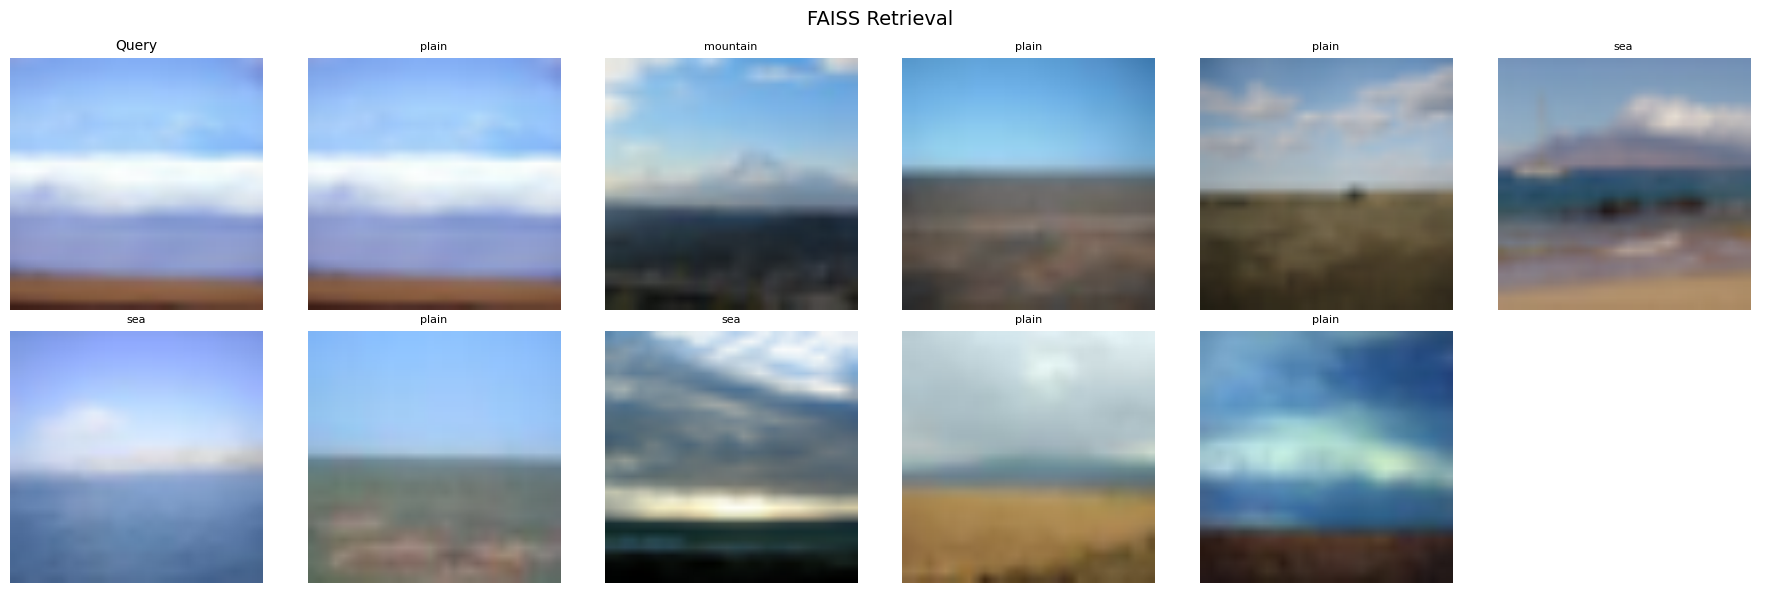

Precision@10: 0.60
False Positive Rate@10: 0.40


In [ ]:
# Run retrieval and evaluation for a customized query index
query_idx = 300  # customized index for testing
run_retrieval(query_idx, model, faiss_index, dataset, k=10)

In [ ]:
def evaluate_metrics(retrieved_indices, query_label, dataset):
    true_positives = 0
    false_positives = 0
    false_negatives = 0
    total_relevant = 0
    total_non_relevant = 0

    database_labels = np.array([label for _, label in dataset])
    retrieved_labels = database_labels[retrieved_indices]
    relevant_items = set(np.where(database_labels == query_label)[0])
    retrieved_set = set(retrieved_indices)
    non_relevant_items = set(np.where(database_labels != query_label)[0])

    tp = len(retrieved_set & relevant_items)
    fp = len(retrieved_set & non_relevant_items)
    fn = len(relevant_items - retrieved_set)

    true_positives += tp
    false_positives += fp
    false_negatives += fn
    total_relevant += len(relevant_items)
    total_non_relevant += len(non_relevant_items)

    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    false_positive_rate = false_positives / total_non_relevant if total_non_relevant > 0 else 0
    return precision, false_positive_rate

def run_multi_query_retrieval(query_indices, top_k_values, model, faiss_index, dataset, device, class_names):
    for query_idx in query_indices:
        query_image, query_label = dataset[query_idx]
        query_input = query_image.unsqueeze(0).to(device)

        with torch.no_grad():
            query_features = model(query_input).cpu().numpy().astype('float32')

        print(f"\n\n--- Query Index: {query_idx} | Label: {class_names[query_label]} ---")

        for k in top_k_values:
            retrieved_indices, _ = retrieve_similar_images_faiss(query_features, faiss_index, k=k)

            # Visualize top-K retrieval
            visualize_retrieval(query_idx, retrieved_indices, dataset, title=f"FAISS Retrieval (Top-{k})", k=k, class_names=class_names)

            # Evaluation metrics
            precision, fpr = evaluate_metrics(retrieved_indices, query_label, dataset)
            print(f"Top-{k} → Precision: {precision:.4f} | False Positive Rate: {fpr:.4f}")


In [ ]:
query_indices = [300, 10, 3330, 1024, 5789]
top_k_values = [10, 20, 30, 40, 50]
class_names = dataset.classes  # For CIFAR100

run_multi_query_retrieval(
    query_indices=query_indices,
    top_k_values=top_k_values,
    model=model,
    faiss_index=faiss_index,
    dataset=dataset,
    device=device,
    class_names=class_names
)

In [ ]:
# prompt: give the precision as table  for the above retrieved imgs

import pandas as pd

def create_precision_table(query_indices, top_k_values, model, faiss_index, dataset, device, class_names):
    data = []
    for query_idx in query_indices:
        query_image, query_label = dataset[query_idx]
        query_input = query_image.unsqueeze(0).to(device)

        with torch.no_grad():
            query_features = model(query_input).cpu().numpy().astype('float32')

        for k in top_k_values:
            retrieved_indices, _ = retrieve_similar_images_faiss(query_features, faiss_index, k=k)
            precision, fpr = evaluate_metrics(retrieved_indices, query_label, dataset)
            data.append([query_idx, class_names[query_label], k, precision, fpr])

    df = pd.DataFrame(data, columns=['Query Index', 'Query Label', 'Top-K', 'Precision', 'FPR'])
    return df

# Example usage (assuming you have the necessary variables defined)
precision_table = create_precision_table(
    query_indices=query_indices,
    top_k_values=top_k_values,
    model=model,
    faiss_index=faiss_index,
    dataset=dataset,
    device=device,
    class_names=class_names
)

precision_table


In [ ]:
from collections import defaultdict

def create_label_index_map(database_labels):
    label_to_indices = defaultdict(set)
    for idx, label in enumerate(database_labels):
        label_to_indices[label].add(idx)
    return label_to_indices

relevant_items = label_to_indices[query_labels[i]]

In [ ]:
retrieved_labels = np.take(database_labels, retrieved_indices[i][:k])
tp = np.sum(retrieved_labels == query_labels[i])

In [ ]:
def compute_metrics_fast(retrieved_indices, query_label, database_labels, k=10):
    # Take only top-k
    retrieved_indices = retrieved_indices[:k]
    retrieved_labels = np.take(database_labels, retrieved_indices)

    true_positives = np.sum(retrieved_labels == query_label)
    false_positives = k - true_positives

    precision = true_positives / k
    fpr = false_positives / (len(database_labels) - np.sum(database_labels == query_label))

    return precision, fpr